Model 1 : XGBoost

- Hyperparameters : {'n_estimators' : 3000, 'learning_rate': 0.02, 'max_depth': 8, 'loss_function':Huber loss}
- Features : Lags, date features , material information transport information
- reduction by a coefficent alpha

## 0) Required environnement
- install the folowing importation (First python cell)
- In the folder "APPEND_CONSULTING_PROJECT" with all data :
1) Create a folder "Model" in "APPEND_CONSULTING_PROJECT" and put this file inside
2) Create a folder "Submissions" in "APPEND_CONSULTING_PROJECT", the submission will be generated inside

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import gc
import json

In [3]:
Positive_Deliveries = True #Set 0 for negative deliveries
weekend0 = True #Set 0 for positive deliveries during the weekend
Remove_RareOccurences=True
forecast_start = pd.Timestamp("2025-01-01")
forecast_end   = pd.Timestamp("2025-05-31")

In [4]:
def print_submission(df_final, filename="submission.csv"):

    df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")

    # 3) Load the ID mapping
    ids = pd.read_csv("../data/prediction_mapping.csv")  # or your actual path
    ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
    ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
    ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
    ids = ids.rename(columns={
        "forecast_end_date": "date"
    })

    # 4) For each ID, get cum at end_date (<= end_date)

    out = (
        ids.merge(df_final, on=["rm_id", "date"], how="left")
        .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
        .sort_values(["rm_id", "date"])
        .reset_index(drop=True)
    )


    # 5) Cum at day before start_date
    submission = (
        out[["ID", "cum"]]
        .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
        .fillna({"predicted_weight": 0})
        .sort_values("ID")
    )

    submission.to_csv("../submissions/" + filename, float_format="%.2f",index=False)
    print(submission.head())

def quantile_error(y_pred, y_test, y_test_keys):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """
    # Concatenate rm_id, y_test, and y_pred into a single DataFrame
    df = y_test_keys.copy()
    df["y_test"] = y_test
    df["y_pred"] = y_pred

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id")["y_test"].cumsum()
    Fi = df.groupby("rm_id")["y_pred"].cumsum()

    q=0.2
    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(q * (Ai - Fi), (1-q) * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02

def quantile_error_df(df):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

        df already contain all these informations
    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id")["y_test"].cumsum()
    Fi = df.groupby("rm_id")["y_pred"].cumsum()

    q=0.2
    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(q * (Ai - Fi), (1-q) * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02


In [ ]:

def find_correlated_lags():
    target = "net_weight"
    
    rec = pd.read_csv('../data/kernel/receivals.csv')
    rec = rec.dropna(subset=["net_weight"])
    rec = rec[rec["net_weight"] > 0]

    rec['date_arrival'] = (
        pd.to_datetime(rec['date_arrival'], utc=True)
        .dt.tz_localize(None)
        .dt.normalize()
    )

    d = (
        rec.groupby(["rm_id","date_arrival"], as_index=False)
                .agg(
                    net_weight_sum=("net_weight", "sum")
                ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
                .sort_values(["rm_id","date"])
    )

    full_start = pd.Timestamp("2004-01-01")
    full_end   = pd.Timestamp("2024-12-31")
    rm_ids = pd.Index(d["rm_id"].unique(), name="rm_id")
    calendar = pd.date_range(full_start, full_end, freq="D", name="date")
    full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

    d = (
        d.set_index(["rm_id","date"])["net_weight"]
            .reindex(full_idx, fill_value=0)
            .reset_index()
    )

    d["net_weight"] = d["net_weight"].astype('float32')

    stat = (
        d.groupby("rm_id")
                .agg(
                    last_delivery=("date", "max"),
                    total_deliveries=("date", "count")  # number of delivery-days
                )
    )
    cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=2)
    cond1 = (stat["last_delivery"] <= cutoff) & (stat["total_deliveries"] <= 30 )
    cond2 =(stat["last_delivery"] <= pd.Timestamp("2006-01-01"))
    rare_rm_id = stat.index[cond1 | cond2]
    
    # I remove rare_rm_id 
    d = d[~d["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

    LAGS_to_test=range(161,160+1000,7)
    # --- lag features ---
    corr_results = []
    for lag in LAGS_to_test:
        lag_col = d.groupby("rm_id")["net_weight"].shift(lag)
        d[f"lf_lag_{lag}"] = lag_col
        corr = d.corrwith(d["net_weight"])[f"lf_lag_{lag}"]
        corr_results.append((lag, corr))
        d.drop(columns=[f"lf_lag_{lag}"], inplace=True)  # Drop to save memory

    # Filter lags with correlation >= 0.5
    lag_numbers = [lag for lag, corr in corr_results if corr >= 0.5]

    return lag_numbers

ALL_LAGS = find_correlated_lags()
print(ALL_LAGS)

1
350
700
1050
128
[161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357, 364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448, 455, 462, 469, 476, 483, 490, 497, 504, 511, 518, 525, 532, 539, 546, 553, 560, 567, 574, 581, 588, 595, 602, 609, 616, 623, 630, 637, 644, 651, 658, 665, 672, 679, 686, 693, 700, 707, 714, 721, 728, 735, 742, 749, 756, 763, 770, 777, 784, 791, 798, 805, 812, 819, 826, 833, 840, 847, 854, 861, 868, 875, 882, 889, 896, 903, 910, 917, 924, 931, 938, 945, 952, 959, 966, 973, 980, 987, 994, 1001, 1008, 1015, 1022, 1085, 1092, 1099, 1106]


In [ ]:
# ---------------------------
# Config: lags & rollings
# ---------------------------
ROLL_WINDOWS    = [7, 14, 30,365]



def create_lag_features(data,removeNA=True):
    target = "net_weight"
    d = data

    # --- rolling aggregates (captures trend / momentum) ---
    for window in ROLL_WINDOWS:
        d[f"lf_roll_mean_{window}"] = d.groupby("rm_id")[target].shift(365).rolling(window).mean().reset_index(level=0, drop=True)
        d[f"lf_roll_std_{window}"] = d.groupby("rm_id")[target].shift(365).rolling(window).std().reset_index(level=0, drop=True)

    # Number of deliveries in the same week/month/year 1 year ago
    d["lf_number_deliveries_1y_ago_week"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(7).sum(), include_groups=False
    ).reset_index(level=0, drop=True)
    d["lf_number_deliveries_1y_ago_month"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(30).sum(), include_groups=False
    ).reset_index(level=0, drop=True)
    d["lf_number_deliveries_1y_ago_year"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(365).sum(), include_groups=False
    ).reset_index(level=0, drop=True)

    # --- lag features ---
    lagged_columns = [
        d.groupby("rm_id")[target].shift(lag)
        for lag in ALL_LAGS
    ]
    d = pd.concat([d] + lagged_columns, axis=1)
    d.columns = list(d.columns[:-len(ALL_LAGS)]) + [f"lf_lag_{lag}" for lag in ALL_LAGS]

    # drop first rows with missing lags
    if removeNA:
        d = d.dropna().reset_index(drop=True)

    return d

def create_calendar_features(df,datecol='date'):
    df[f"{datecol}_year"] = df[datecol].dt.year-2004
    df[f"{datecol}_month"] = df[datecol].dt.month
    df[f"{datecol}_week"] = df[datecol].dt.isocalendar().week
    df[f"{datecol}_dayofmonth"] = df[datecol].dt.day 
    df[f"{datecol}_dayofweek"] = df[datecol].dt.dayofweek
    df[f"{datecol}_dayofyear"] = df[datecol].dt.dayofyear
    df[f"{datecol}_isweekend"] = df[datecol].dt.dayofweek.isin([5,6])
    #df[f"{datecol}_isaugust"] = df[datecol].dt.month.isin([8]) => worse results
    #df[f"{datecol}_isdecember"] = df[datecol].dt.month.isin([12])
    return df





In [15]:
# Delete large objects explicitly
if 'daily_receivals' in globals():
    del daily_receivals
if 'd' in globals():
    del d

# Force garbage collection
gc.collect()

receivals = pd.read_csv('../data/kernel/receivals.csv')
receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

daily_receivals = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)
daily_receivals["net_weight"] = daily_receivals["net_weight"].astype('float32')

# Static features
# Calculate the total sum of net_weight for each rm_id
# Calculate both the total sum and the count of deliveries > 0

static_fields_pr_rm_id = (
    daily_receivals
    .groupby("rm_id", as_index=False)
    .agg(
        total_net_weight_all_time=("net_weight", "sum"),
        mean_net_weight_all_time=("net_weight", "mean"),
        med_net_weight_all_time=("net_weight", "median"),
        num_deliveries_all_time=("net_weight", lambda x: (x > 0).sum()),
        date_last_delivery=("date", "min")
    )
)
static_fields_pr_rm_id["delay_last_delivery"] = (pd.Timestamp("2025-01-01")- static_fields_pr_rm_id["date_last_delivery"]).dt.days
static_fields_pr_rm_id = static_fields_pr_rm_id.drop(columns=("date_last_delivery"))

if Remove_RareOccurences:
    stats = (
        daily_receivals.groupby("rm_id")
                .agg(
                    last_delivery=("date", "max"),
                    total_deliveries=("date", "count")  # number of delivery-days
                )
    )
    cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=2)
    cond1 = (stats["last_delivery"] <= cutoff) & (stats["total_deliveries"] <= 30 )
    cond2 =(stats["last_delivery"] <= pd.Timestamp("2006-01-01"))
    rare_rm_id = stats.index[cond1 | cond2]
    print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")
    print(f"number :  {len(rare_rm_id)}")
    
    # I remove rare_rm_id 
    daily_receivals = daily_receivals[~daily_receivals["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

full_start = pd.Timestamp("2004-01-01")
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

daily_receivals = (
    daily_receivals.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)

# Merge both back into the original DataFrame
daily_receivals = daily_receivals.merge(
    static_fields_pr_rm_id,
    on="rm_id",
    how="left"
)

daily_receivals=create_lag_features(daily_receivals)
daily_receivals=create_calendar_features(daily_receivals,datecol='date')
daily_receivals = daily_receivals.sort_values(["rm_id","date"]).reset_index(drop=True)



We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,  358.0,  360.0,  362.0,  364.0,  365.0,  366.0,  367.0,  368.0,
        369.0,  374.0,  375.0,  378.0,  379.0,  380.0,  381.0,  383.0,  387.0,
        388.0,  389.0,  390.0, 1842.0, 1843.0, 1844.0, 1845.0, 1846.0, 1850.0,
       1851.0, 1852.0, 1853.0, 1854.0, 1857.0, 1858.0, 1866.0, 1867.0, 1868.0,
       1871.0, 1872.0, 1873.0, 1874.0, 1882.0, 1981.0, 2001.0, 2061.0, 2102.0,
       2121.0, 2122.0, 2128.0, 2139.0, 2141.0, 2148.0, 2156.0, 2158.0, 2201.0,
       2223.0, 2282.0, 2283.0, 2285.0, 2302.0, 2304.0, 2322.0, 2323.0, 2341.0,
       2343.0, 2344.0, 2345.0, 2347.0, 2348.0, 2362.0, 2363.0, 2402.0, 2421.0,
       2481.0, 2521.0, 2561.0, 2742.0, 2821.0, 2841.0, 2861.0, 3022.0, 3101.0,
       3144.0, 3222.0, 3241.0, 3481.0, 3501.0, 3541.0],
      dtype='float64', name='rm_id')
number :  96


In [16]:
def flag_any(x, patterns):
    if not isinstance(x, str):
        return 0
    x = x.lower()
    return int(any(p in x for p in patterns))

In [17]:
materials = pd.read_csv('../data/extended/materials.csv')
materials = materials.dropna(subset=["rm_id"])

materials["fam_6xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["6060","6063","6082","6005","6016"]))
materials["fam_5xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["5000","5754"]))
materials["fam_1xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["1050","1100"]))
materials["fam_pure"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["99.5","99,5","99.7","99,7","cspa","pm al","granalla","coil"]))
materials["fam_scrap_shred"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["shredd","tritura","scrap"]))
materials["fam_briquetas"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["briquet","compact"]))
materials["fam_mele"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["melé","cacharro"]))
materials["fam_master"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, [" si "," mg "," mn "," cu "," cr "," fe ","ti-bors","wire","cable"]))
materials["treat_lacado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["lac","paint"]))
materials["treat_anodizado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["anod"]))
materials["treat_thermal_break"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["thermal break","puente t"]))

materials["loc_SB"] = materials["stock_location"].map(lambda x: flag_any(x, ["sb"]))
materials["loc_SA"] = materials["stock_location"].map(lambda x: flag_any(x, ["sa"]))
materials["loc_SC"] = materials["stock_location"].map(lambda x: flag_any(x, ["sc"]))
materials["loc_AA"] = materials["stock_location"].map(lambda x: flag_any(x, ["aa"]))
materials["loc_PM"] = materials["stock_location"].map(lambda x: flag_any(x, ["pm "]))

materials["loc_ThermalBreak"] = materials["stock_location"].map(lambda x: flag_any(x, ["thermal break","puente t"," pt"]))
materials["loc_Lavadero"] = materials["stock_location"].map(lambda x: flag_any(x, ["lavadero"]))
materials["loc_Granalla"] = materials["stock_location"].map(lambda x: flag_any(x, ["granalla"]))
materials["loc_Briquetas"] = materials["stock_location"].map(lambda x: flag_any(x, ["briquet"]))


# your flag columns already created above (fam_*, treat_*, loc_*)
flag_cols = [c for c in materials.columns if c.startswith(("fam_", "treat_", "loc_"))]

# Group and aggregate:
# - flags: max (so any 1 across the rm_id becomes 1)
# - format type: mean
# - keep a representative text for context (first)

materials_by_rm = (
    materials
    .groupby("rm_id", as_index=False)
    .agg({**{c: "mean" for c in flag_cols},
            "raw_material_format_type": "mean"})
)

# (optional) if you prefer ints for flags (0/1), cast them:
for c in flag_cols:
    materials_by_rm[c] = materials_by_rm[c].astype(int)


In [18]:
transportation = pd.read_csv('../data/extended/transportation.csv')

transportation = transportation.dropna(subset=["purchase_order_id","net_weight","rm_id"])

#df_nan = transportation[transportation["purchase_order_id"].isna()] # no more nan values
#print(df_nan) #now empty
weight_cols = ["vehicle_start_weight","vehicle_end_weight",
               "gross_weight","tare_weight","net_weight"]
for c in weight_cols:
    transportation[c] = pd.to_numeric(transportation[c], errors="coerce")

# --- One-hot encode transporter_name -> 0/1 columns
transp_dum = pd.get_dummies(
    transportation["transporter_name"],
    prefix="_",
    dummy_na=False  # set True if you want a "transp_nan" column for missing
)

# attach dummies
transportation = pd.concat([transportation, transp_dum], axis=1)

# --- Build aggregation dict:
#     - transporter dummies: mean (→ proportion of trips with that transporter per rm_id)
#     - weights: mean
agg_dict = {**{c: "max" for c in transp_dum.columns},
            **{c: "mean" for c in weight_cols}}

transportation_by_rm = (
    transportation
    .groupby("rm_id", as_index=False)
    .agg(agg_dict)
)

# pretty rounding for proportions/means
transportation_by_rm[transp_dum.columns] = transportation_by_rm[transp_dum.columns].round(3)
transportation_by_rm[weight_cols] = transportation_by_rm[weight_cols].round(3)
transportation_by_rm=transportation_by_rm.rename(columns={'net_weight': 'transp_mean_weight'})

In [19]:
df_all = (
    daily_receivals
    .merge(materials_by_rm, on="rm_id", how="left")
    .merge(transportation_by_rm, on="rm_id", how="left")
)
df_all = df_all.sort_values(["rm_id","date"]).reset_index(drop=True)


In [20]:
columns_keys=["rm_id","date"]
columns_output = ['net_weight']
columns_input = [c for c in df_all.columns if c not in ["rm_id","date","net_weight"]]

def split_set_Train_Test(df_all, test_size=0.05):
    if test_size == 2024:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:-366])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[-366:])
    elif test_size == 0.:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:-1])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[-1:])

    else:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:int((1-test_size) * len(x))])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[int((1-test_size) * len(x)):])

    X_train_keys= train[columns_keys]
    X_train = train[columns_input]
    y_train = train[columns_output].values.ravel()

    X_test_keys= test[columns_keys]
    X_test = test[columns_input]
    y_test = test[columns_output].values.ravel()

    X_train_keys=X_train_keys.reset_index(drop=True)
    X_test_keys=X_test_keys.reset_index(drop=True)
    
    return X_train_keys, X_train, y_train, X_test_keys, X_test, y_test

In [21]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(df_all, test_size=0.)

C:\Users\julie\AppData\Local\Temp\ipykernel_13300\3598047402.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df_all.groupby('rm_id').apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_13300\3598047402.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df_all.groupby('rm_id').apply(


In [22]:
# {'n_estimators' : 1000, 'learning_rate': 0.02, 'max_depth': 4} good model for qf (objective = squarederror)
# {'n_estimators' : 500, 'learning_rate': 0.02, 'max_depth': 6} good model (objective = squarederror)
# {'n_estimators' : 2000, 'learning_rate': 0.01, 'max_depth': 4} same (objective = squarederror)
# {'n_estimators' : 2000, 'learning_rate': 0.02, 'max_depth': 8} same (objective = pseudohubererror)
# {'n_estimators' : 3000, 'learning_rate': 0.02, 'max_depth': 8} same (objective = pseudohubererror) => best model (for absolute error)
# Train XGBoost
model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    n_estimators=3000,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Faster for large datasets
)
print("The training start")

model.fit(X_train, y_train)



The training start


,objective,'reg:pseudohubererror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [23]:
data_for_forecast = df_all[df_all["date"]>=pd.Timestamp("2023-01-01")].copy()
cols_to_drop = [col for col in data_for_forecast.columns
                if col.startswith("lf_")] # => all lag features
data_for_forecast = data_for_forecast.drop(columns=cols_to_drop, errors="ignore")

forecast_range = pd.date_range(forecast_start, forecast_end, freq="D", name="date")

rm_ids = pd.Index(data_for_forecast["rm_id"].unique(), name="rm_id")
static_cols = [c for c in data_for_forecast.columns
                    if c not in {"date","net_weight"} and not c.startswith(("lf_","date_"))]
static_map = (
    data_for_forecast
      .drop_duplicates(subset=["rm_id"], keep="first")[[*static_cols]]
)


multi_index = pd.MultiIndex.from_product(
    [rm_ids, forecast_range],
    names=["rm_id", "date"]
)
# Create the base DataFrame
forecast_base_df = pd.DataFrame(index=multi_index).reset_index()
forecast_base_df=create_calendar_features(forecast_base_df,'date')
forecast_base_df = forecast_base_df.merge(static_map, on="rm_id", how="left")

# attach to the base grid

data_for_forecast = pd.concat([data_for_forecast, forecast_base_df])
data_for_forecast=data_for_forecast.sort_values(["rm_id","date"]).reset_index(drop=True)
data_for_forecast= create_lag_features(data_for_forecast,removeNA=False)
input_rows = data_for_forecast.loc[
    data_for_forecast['date'] >=forecast_start,
    columns_input
    ]


In [24]:
preds = model.predict(input_rows)

data_for_forecast.loc[
    data_for_forecast['date'] >= forecast_start, 'net_weight'
] = preds

if Positive_Deliveries:
    data_for_forecast["net_weight"] = data_for_forecast["net_weight"].clip(lower=0)

# assign value 0 for the weekend
if weekend0:
    data_for_forecast.loc[data_for_forecast['date_isweekend'] == True, 'net_weight'] = 0
#------------------------ Apply a coefficient to have smaller deliveries -----------------
if weekend0:
    data_for_forecast.loc[data_for_forecast['date_isweekend'] == True, 'net_weight'] = 0

df_pred_2025 = data_for_forecast[data_for_forecast['date'] >= forecast_start]


rm_id to test :
2121. 2123. 2124. 2125. 2129. 2130. 2131. 2132. 2133. 2134. 2135. 2138.
 2140. 2142. 2143. 2144. 2145. 2147. 2153. 2160. 2161. 2284. 2401. 2402.
 2482. 2521. 2561. 2601. 2741. 2742. 2761. 2821. 2981. 3005. 3121. 3122.
 3123. 3124. 3125. 3126. 3142. 3161. 3162. 3201. 3241. 3265. 3282. 3362.
 3381. 3421. 3441. 3601. 3621. 3642. 3701. 3761. 3762. 3781. 3841. 3865.
 3883. 3901. 3941. 4021. 4081. 4222. 4263. 4302. 4441. 4443.

 2130.0, 4263.0, 4501.0 (last rm_id)
 


In [25]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(df_all, test_size=2024)
## the test set must contain only 2024 data*

C:\Users\julie\AppData\Local\Temp\ipykernel_13300\3598047402.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df_all.groupby('rm_id').apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_13300\3598047402.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df_all.groupby('rm_id').apply(


argmin is 0.9999999999999998
min is 57052.41573712156


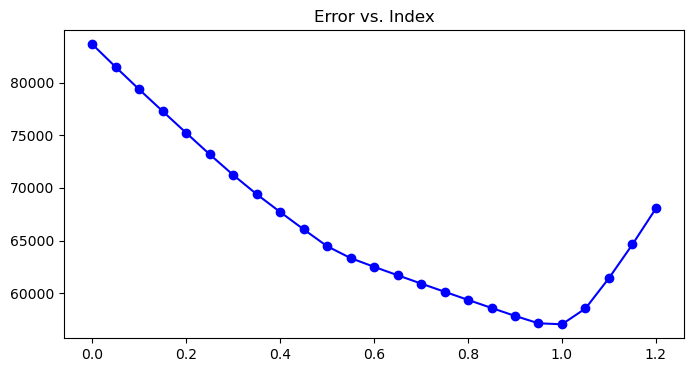

In [26]:
y_pred=model.predict(X_test)

df=X_test_keys.copy()
df["y_test"]=y_test
df["y_pred"]=y_pred

if Positive_Deliveries:
    df["y_pred"] = df["y_pred"].clip(lower=0)

# assign value 0 for the weekend

if weekend0:
    df['day_of_week'] = df['date'].dt.dayofweek
    df.loc[df['day_of_week'].isin([5, 6]), 'y_pred'] = 0
    df = df.drop(columns=['day_of_week'])


err_min=np.inf
alpha_min=1
errs=[]
for alpha in np.arange(1.2, -0.01, -0.05):
    df["y_pred"] = alpha*y_pred
    err = quantile_error_df(df)
    errs.append(err)
    if err <= err_min:
        alpha_min = alpha
        err_min=err
print(f"argmin is {alpha_min}")
print(f"min is {err_min}") # before = 57288
plt.figure(figsize=(8, 4))  # Optional: Set figure size
plt.plot(np.arange(1.2, -0.01, -0.05), errs, marker='o', linestyle='-', color='b')  # Plot with markers and line
plt.title('Error vs. Index')  # Title
plt.show()  # Display the plot



In [27]:
#Fichier des predictions
# reduction_by_coefficient in the hyperparameters

if True:
    reduction_by_coefficient=1
    if reduction_by_coefficient !=1:
        df_pred_2025.loc[:, "net_weight"] = df_pred_2025["net_weight"] * reduction_by_coefficient

df_final_cum  = (
    df_pred_2025.groupby("rm_id", as_index=False)
        .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
        .reset_index(drop=True)
        [["rm_id", "date", "cum"]]
)


C:\Users\julie\AppData\Local\Temp\ipykernel_13300\1284978104.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))


In [28]:
print_submission(df_final_cum,filename="XGBoost-9700.csv")

      ID  predicted_weight
2100   1               0.0
2101   2               0.0
2102   3               0.0
2103   4               0.0
2104   5               0.0
